# Spaceship Titanic Supervised Learning

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# EDA (Exploratory Data Analysis)

In [32]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

train_head = train_data.head()
test_head = test_data.head()
print(train_head)
print(test_head)

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
  

In [3]:
data_summary = train_data.describe(include='all')
data_summary

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [4]:
missing_values = train_data.isnull().sum()
missing_values

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

In [6]:
transported_distribution = train_data['Transported'].value_counts(normalize=True)
transported_distribution

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

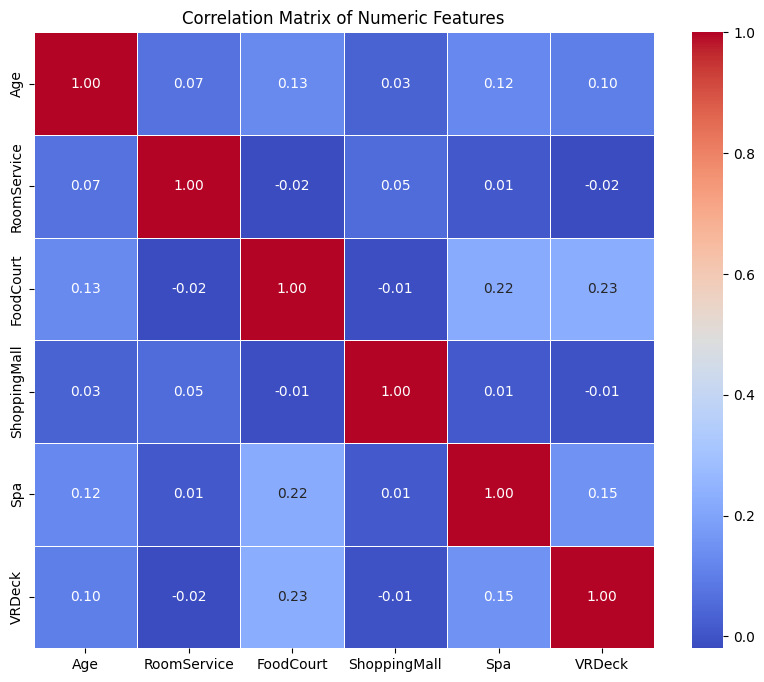

In [7]:
numeric_data = train_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

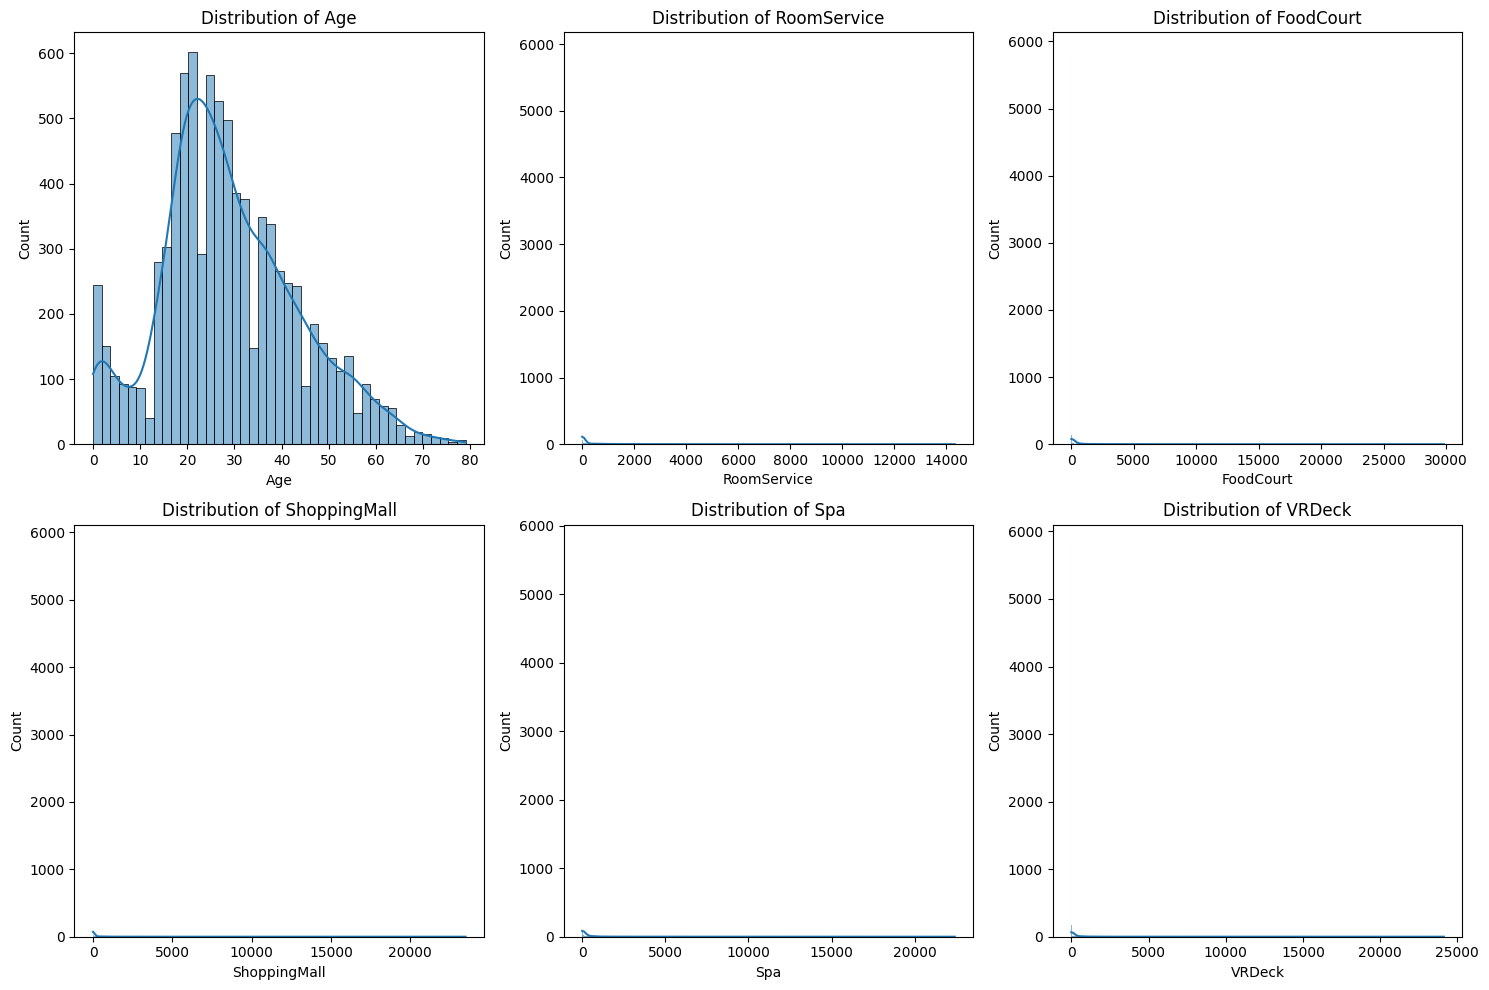

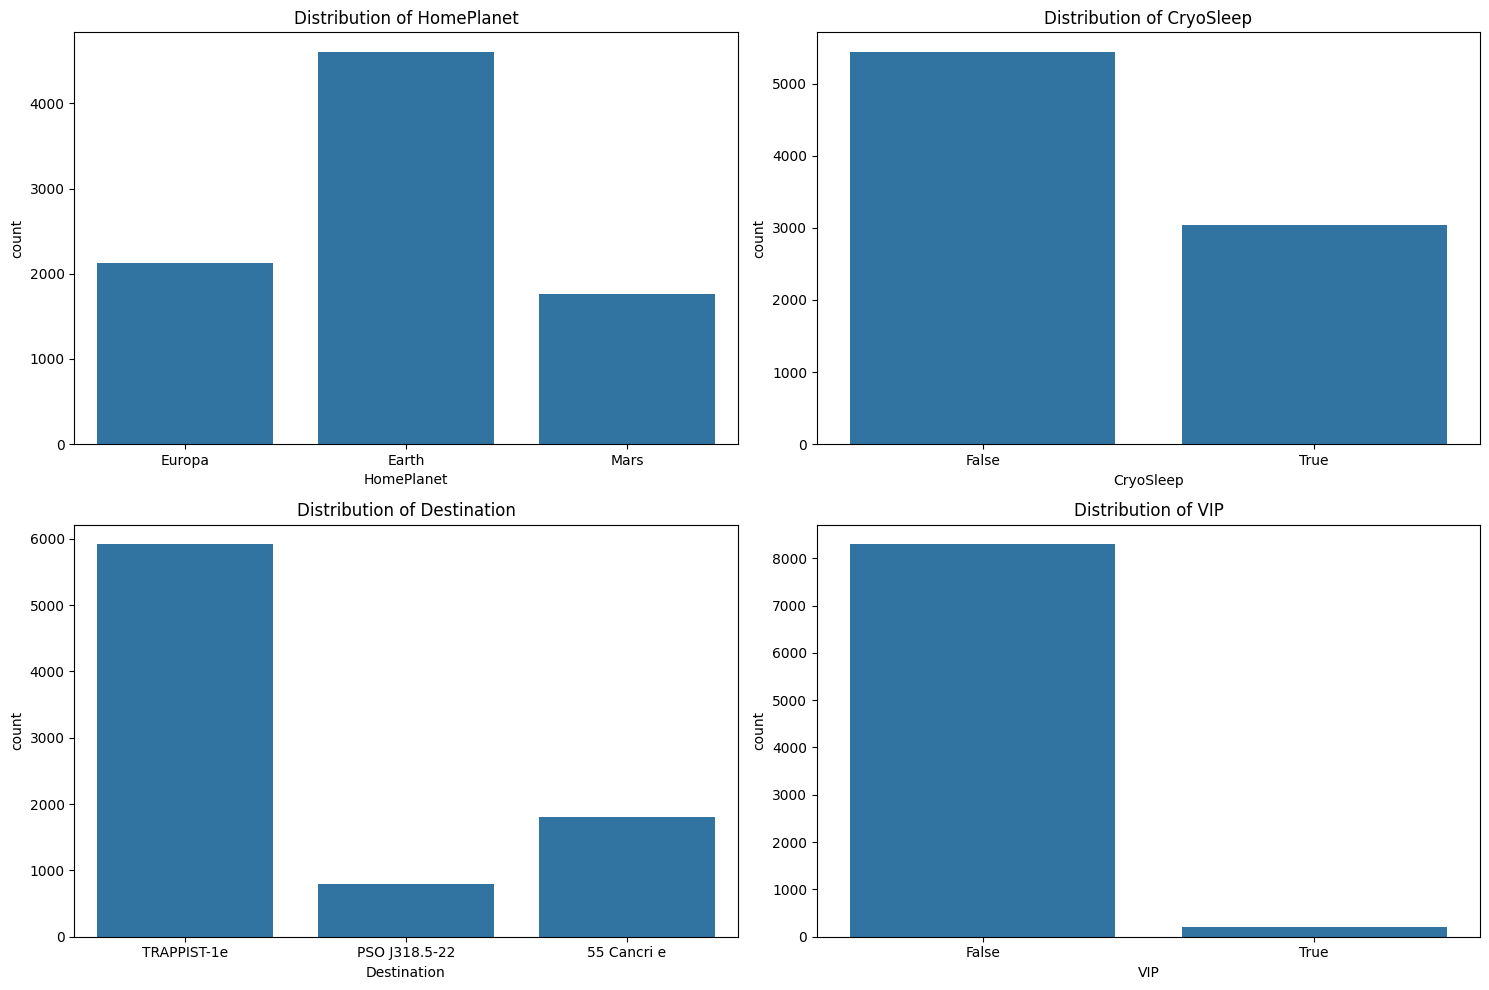

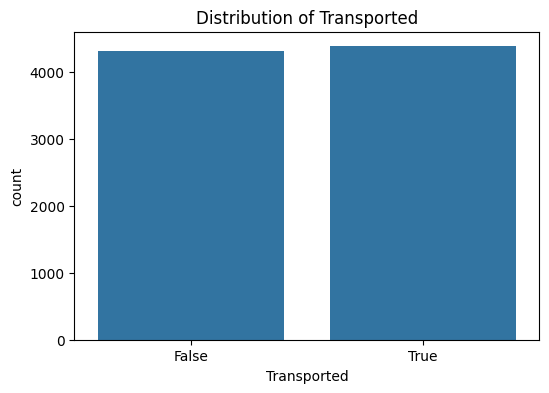

In [8]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=feature, data=train_data)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()

plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', data=train_data)
plt.title('Distribution of Transported')
plt.show()

# EDA Analysis

There are some missing values in every column. We must decide how to deal with that. Let's reclassify the categorical data to be 'Unknown' and the numerical data to be mean. There is about a 50/50 split between our target variable, Transported. The variables are not correlated to each other much at all, as you can see from the confusion matrix.

In [19]:
def preprocess_data(dataset, preprocessor=None):
    '''Pipeline to process data. Pipelines are more efficient and standard practice'''
    #Identify col type
    numerical_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = dataset.select_dtypes(include=['object', 'bool']).columns

    #Replaces missing num values with mean
    if preprocessor is None:
        numerical_transformer = SimpleImputer(strategy='mean')
    
        #Replaces missing cat values with Unknown
        categorical_transformer = Pipeline(steps=[
            ('bool_to_str', FunctionTransformer(lambda x: x.astype(str))),
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
    
        # Creates transformer
        new_preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

    # Applies transformer
    preprocessed_data = new_preprocessor.fit_transform(dataset) if preprocessor is None else preprocessor.transform(dataset)

    # Returns a sparse matrix bc more efficient than pd df - OHE 
    # Need to save preprocessor for later to apply on Test set
    if preprocessor is None:
        return preprocessed_data, new_preprocessor
    else:
        return preprocessed_data, preprocessor

In [24]:
y = train_data['Transported']
X = train_data.drop('Transported', axis=1)

X_processed, processor = preprocess_data(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=0)

<6954x23748 sparse matrix of type '<class 'numpy.float64'>'
	with 68335 stored elements in Compressed Sparse Row format>

In [11]:
def custom_svc(X_train, X_test, y_train, y_test, C=1.0, kernel='rbf', degree=3, gamma='scale', probability=True):
    svm_model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, probability=probability)
    svm_model.fit(X_train, y_train)
    
    
    y_pred = svm_model.predict(X_test)
    
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])

    print('Accuracy: ', accuracy)
    print('Recall: ', recall)
    print('ROC-AUC Score: ', roc_auc)
    return svm_model

In [12]:
svc = custom_svc(X_train, X_test, y_train, y_test)

Accuracy:  0.7780333525014376
Recall:  0.8789954337899544
ROC-AUC Score:  0.8423083435186802


In [13]:
grid = {
    'C': [0.5, 1, 5],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'],
}

grid_search = GridSearchCV(SVC(degree=3, probability=True), grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [14]:
best_params

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [21]:
best_svc = custom_svc(X_train, X_test, y_train, y_test, C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])

Accuracy:  0.7780333525014376
Recall:  0.8789954337899544
ROC-AUC Score:  0.8423017296570846


In [25]:
test_processed, processor = preprocess_data(test_data, processor)
y_pred = best_svc.predict(test_processed)
y_pred

array([ True, False,  True, ...,  True,  True,  True])

In [30]:
test_predictions = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Transported': np.around(y_pred.flatten())
})
test_predictions['Transported'] = test_predictions['Transported'].apply(lambda x: True if x == 1 else False)
test_predictions.to_csv('./submission_final.csv', index=False)

# Results

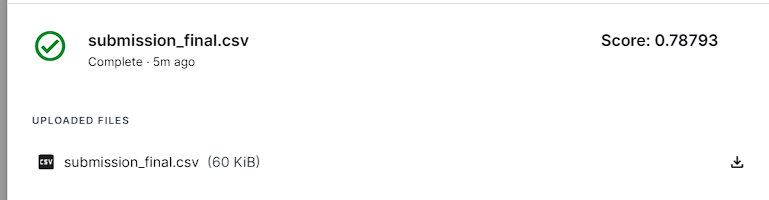

# Conclusion

In conclusion, the SVM worked fairly well, although i have a feeling that regression would have been best in this scenario due to similarities within the famous Titanic dataset. I also didnt run many grid searches, as I dont have the memory and CPU power to run long tunings. Overall it gave an accuracy of 0.778 which is very close to the submission score of 0.788. I think if i tuned it a little better i could have a model over 85%+ accuracy.